<a href="https://colab.research.google.com/github/Mario-RJunior/olist-e-commerce/blob/master/time_series_analysis_testes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Análise Temporal

Nesta etapa do trabalho estaremos focados em estudar sobre a sazonalidade e as tendências das compras online e para isso faremos uma análise utilizando as séries temporais correspondentes. Como produto final iremos criar um modelo preditivo, ou seja, fazer um **forecast** para estipular as vendas em instantes futuros.

Assim, nosso primeiro passo é importar as bibliotecas a serem utilizadas e carregar os dados que precisaremos para tal análise.

### 1) Importando e carregando os dados

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
from datetime import datetime, date

In [ ]:
! git clone https://github.com/Mario-RJunior/olist-e-commerce

Cloning into 'olist-e-commerce'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 545 (delta 95), reused 0 (delta 0), pack-reused 380
Receiving objects: 100% (545/545), 36.37 MiB | 20.79 MiB/s, done.
Resolving deltas: 100% (323/323), done.


Inicialmente iremos selecionar as colunas que iremos utilizar e a seguir agrupá-las para gerar o dataframe.

In [ ]:
# Selecionando as colunas para uso
orders_col = ['order_id', 'order_status', 'order_purchase_timestamp', 
              'order_approved_at', 'order_delivered_carrier_date', 
              'order_delivered_customer_date', 'order_estimated_delivery_date']
orders_items_col = ['order_id', 'shipping_limit_date', 'price']

In [ ]:
# Carregando os datasets
orders = pd.read_csv('olist-e-commerce/datasets/olist_orders_dataset.csv', 
                     usecols=orders_col)
orders_items = pd.read_csv('olist-e-commerce/datasets/olist_order_items_dataset.csv', 
                           usecols=orders_items_col)

In [ ]:
# Junção dos dataframes
df = pd.merge(right=orders_items,
             left=orders,
             on='order_id')

In [ ]:
df.head()

,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,price
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10-06 11:07:15,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-07-30 03:24:27,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,2018-08-13 08:55:23,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,2017-11-23 19:45:59,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,2018-02-19 20:31:37,19.90


### 2) Verificando a consistência dos dados

In [ ]:
df.shape

(112650, 9)

- Verificando os tipos das variáveis.

In [ ]:
# Tipo das variáveis
df.dtypes

order_id                          object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
shipping_limit_date               object
price                            float64
dtype: object

Agora, como desejamos trabalhar com séries temporais devemos então converter as respectivas colunas para o formato *datetime*, uma vez que elas estão originalmente no formato *object*.

In [ ]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['shipping_limit_date'] = pd.to_datetime(df['shipping_limit_date'])

Uma vez convertidas para datetime iremos fazer mais um tratamento, sobretudo na coluna "order_purchase_timestamp". Como queremos analisar o comportamento das compras diárias tais como tendência e sazonalidade, iremos remover a hora de cada registro e considerar apenas as datas em que as compras ocorreram.


In [ ]:
# Pegando apenas a data da coluna "order_purchase_timestamp"
df['order_purchase_timestamp'] = df['order_purchase_timestamp'].apply(lambda x: x.date())

# Convertendo novamente a data diária para formato datetime
df['order_purchase_timestamp'] = df['order_purchase_timestamp'].apply(lambda x: datetime(x.year, x.month, x.day))

In [ ]:
# Confirmando os tipos de dados
df.dtypes

order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
shipping_limit_date              datetime64[ns]
price                                   float64
dtype: object

In [ ]:
# Verificando a existência de valores nulos
df.isnull().sum()

order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
shipping_limit_date                 0
price                               0
dtype: int64

### 3) Explorando e tratando a base de dados

In [ ]:
# Verificando as datas da primeira e da última compra
print('Data mínima: {} \nData máxima: {}'.format(df['order_purchase_timestamp'].min(), 
                                                 df['order_purchase_timestamp'].max()))

Data mínima: 2016-09-04 00:00:00 
Data máxima: 2018-09-03 00:00:00


In [ ]:
df.groupby([df['order_purchase_timestamp'].dt.year,
           df['order_purchase_timestamp'].dt.month]).count()['order_id']

order_purchase_timestamp  order_purchase_timestamp
2016                      9                              6
                          10                           363
                          12                             1
2017                      1                            955
                          2                           1951
                          3                           3000
                          4                           2684
                          5                           4136
                          6                           3583
                          7                           4519
                          8                           4910
                          9                           4831
                          10                          5322
                          11                          8665
                          12                          6308
2018                      1                           8208
     

Note que no ano de 2016 temos alguns valores que não apresentam-se coerentes com o restante dos meses. Portanto iremos desconsiderar tais valores e criar o modelo utilizando todo o ano de 2017 e os nove meses de 2018.

Note ainda que do resultado acima é possível perceber que os dados referentes a 2016 somam 370 registros. Logo, iremos ordernar estas datas, criar uma lista com os índices de todos os 370 registros e deletar tais linhas.

In [ ]:
# Criando uma lista com os índices
ano_2016_index = df['order_purchase_timestamp'].sort_values().index[:370]
ano_2016_index

Int64Index([  5085,   5086,   4925,  34804,  34802,  34803,  93991, 110955,
            100101,  70259,
            ...
             77891,  28766,  92287, 103736,  59722,  59721,  59723,  35343,
             90652,  45006],
           dtype='int64', length=370)

In [ ]:
# Excluindo estas linhas
df.drop(index=ano_2016_index, inplace=True)

In [ ]:
# Fazendo uma nova verificação
df.groupby([df['order_purchase_timestamp'].dt.year,
           df['order_purchase_timestamp'].dt.month]).count()['order_id']

order_purchase_timestamp  order_purchase_timestamp
2017                      1                            955
                          2                           1951
                          3                           3000
                          4                           2684
                          5                           4136
                          6                           3583
                          7                           4519
                          8                           4910
                          9                           4831
                          10                          5322
                          11                          8665
                          12                          6308
2018                      1                           8208
                          2                           7672
                          3                           8217
                          4                           7975
     

### 4) Plotando comportamento das séries temporais

Agora, iremos definir duas bases de dados:

1) Considerando a quantidade de produtos que foram vendidos por mês.

2) Considerando o valor obtido por mês.

A seguir, iremos fazer um gráfico para cada situação para entender o comportamento das séries em ambos os casos.

- Plotando os dados para a quantidade de produtos vendidos mensalmente

In [ ]:
df_group_quant = df.groupby(df['order_purchase_timestamp']).count()['order_id']
df_group_quant

order_purchase_timestamp
2017-01-05    32
2017-01-06     4
2017-01-07     5
2017-01-08     6
2017-01-09     6
              ..
2018-08-26    82
2018-08-27    71
2018-08-28    45
2018-08-29    16
2018-09-03     1
Name: order_id, Length: 603, dtype: int64

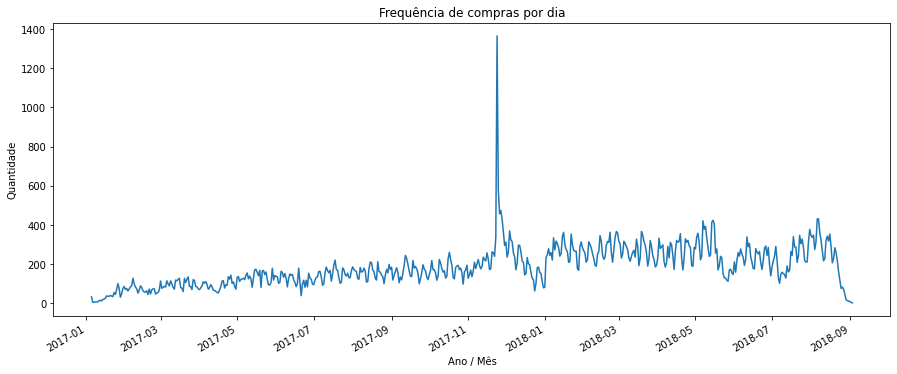

In [ ]:
df_group_quant.plot(figsize=(15,6))
plt.title('Frequência de compras por dia')
plt.xlabel('Ano / Mês')
plt.ylabel('Quantidade')
plt.show()

- Plotando os dados para o total de dinheiro arrecadado pelas vendas mensalmente

In [ ]:
df_group_price = df.groupby(df['order_purchase_timestamp']).sum()['price']
df_group_price

order_purchase_timestamp
2017-01-05     396.90
2017-01-06     916.38
2017-01-07    1351.90
2017-01-08     709.58
2017-01-09     673.79
               ...   
2018-08-26    8070.71
2018-08-27    5345.91
2018-08-28    3673.91
2018-08-29    1546.04
2018-09-03     145.00
Name: price, Length: 603, dtype: float64

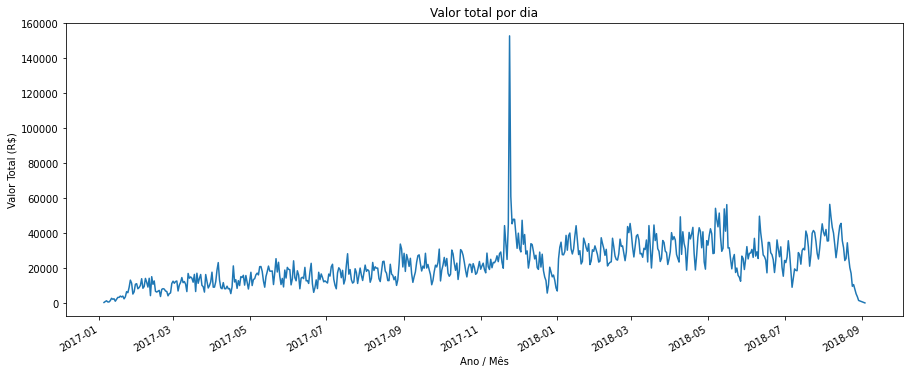

In [ ]:
df_group_price.plot(figsize=(15,6))
plt.title('Valor total por dia')
plt.xlabel('Ano / Mês')
plt.ylabel('Valor Total (R$)')
plt.show()

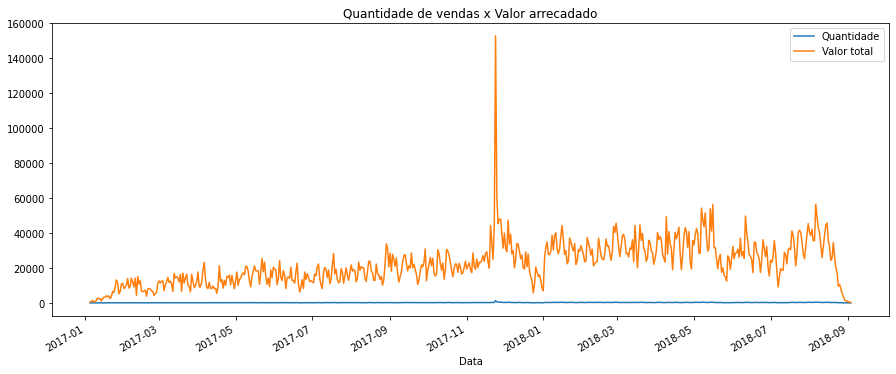

In [ ]:
# Plotando ambos os gráficos juntos
df_group_quant.plot(figsize=(15,6), label='Quantidade')
df_group_price.plot(figsize=(15,6), label='Valor total')
plt.title('Quantidade de vendas x Valor arrecadado')
plt.xlabel('Data')
plt.legend(loc='best')
plt.show()

Note que apesar de ambos os gráficos serem muito semelhantes eles apresentam-se em escalas bem diferentes o que faz com que o gráfico da quantidade fique praticamente uma linha reta em relação ao dos preços.

### 5) Fazendo o forecast e analisando tendência e sazonalidade

- Criação do modelo usando o Prophet

Nesta etapa iremos utilizar a biblioteca fbprophet para gerar um modelo com o intuito de encontrar sazonalidade, tendência e fazer algumas previsões para compras nos meses futuros.

A seguir, precisaremos criar um dataframe apropriado para utilização do Prophet em ambos os casos.

In [ ]:
# Criação do modelo
model_quant = Prophet(yearly_seasonality=True)
model_preco = Prophet(yearly_seasonality=True)

In [ ]:
# Adicionando sazonalidade mensal
model_quant.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_preco.add_seasonality(name='monthly', period=30.5, fourier_order=5)

- Criando os respectivos dataframes

1) Considerando a quantidade de vendas

In [ ]:
# Criação do dataframe das quantidades
ts_quant = df.groupby('order_purchase_timestamp').count()['order_id'].reset_index()
ts_quant.rename(columns= {
    'order_purchase_timestamp': 'ds',
    'order_id': 'y'
    }, inplace=True)
ts_quant.head()

,ds,y
0,2017-01-05,32
1,2017-01-06,4
2,2017-01-07,5
3,2017-01-08,6
4,2017-01-09,6


2) Considerando o preço total das vendas

In [ ]:
# Criando o dataframe do valor total das vendas
ts_preco = df.groupby('order_purchase_timestamp').sum()['price'].reset_index()
ts_preco.rename(columns= {
    'order_purchase_timestamp': 'ds',
    'price': 'y'
    }, inplace=True)
ts_preco.head()

,ds,y
0,2017-01-05,396.90
1,2017-01-06,916.38
2,2017-01-07,1351.90
3,2017-01-08,709.58
4,2017-01-09,673.79


- Treinando o modelo e fazendo a previsão

Agora, iremos fazer o treinamento para os dois casos acima e a seguir fazer as respectivas previsões.

1) Considerando a quantidade de vendas

In [ ]:
# Fazendo o treinamento
model_quant.fit(ts_quant)

# Criando um dataframe para dados futuros
future_quant = model_quant.make_future_dataframe(periods = 30, freq = 'D')

# Fazendo a previsão
forecast_quant = model_quant.predict(future_quant)
forecast_quant[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
603,2018-09-04,208.819267,131.747673,283.115954
604,2018-09-05,210.465350,134.478503,282.540473
605,2018-09-06,210.756019,137.436303,283.635683
606,2018-09-07,204.301535,127.889445,278.692337
607,2018-09-08,155.696554,82.552555,231.055097
608,2018-09-09,165.250100,84.234530,244.179580
609,2018-09-10,219.733504,135.754029,297.449034
610,2018-09-11,224.976120,149.182713,304.661619
611,2018-09-12,225.212587,146.078221,298.036060
612,2018-09-13,223.019149,152.063702,293.008565


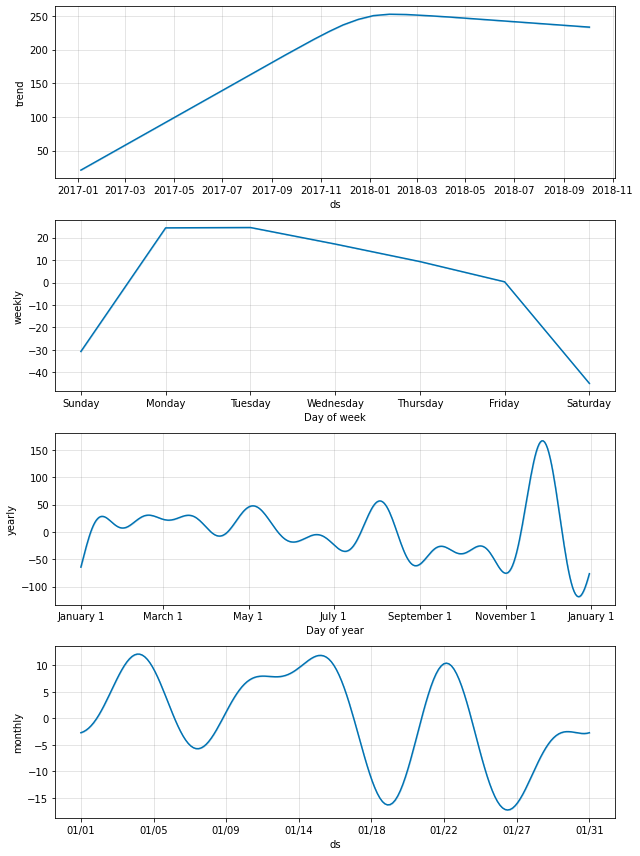

In [ ]:
# Plotando os gráficos de tendência
model_quant.plot_components(forecast_quant);

2) Considerando o preço total das vendas

In [ ]:
# Fazendo o treinamento
model_preco.fit(ts_preco)

# Criando um dataframe para dados futuros
future_preco = model_preco.make_future_dataframe(periods = 30, freq = 'D')

# Fazendo a previsão
forecast_preco = model_preco.predict(future_preco)
forecast_preco[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
603,2018-09-04,28652.081344,20181.081548,37623.790117
604,2018-09-05,29216.894198,20758.413677,37990.512141
605,2018-09-06,29151.575614,19805.107860,38794.106233
606,2018-09-07,28501.692504,19154.643445,37033.121966
607,2018-09-08,22635.967584,12632.514921,31725.212824
608,2018-09-09,23348.718829,14352.364543,32620.058224
609,2018-09-10,30761.557839,20917.968458,39621.030427
610,2018-09-11,31036.258059,21630.661573,40104.686482
611,2018-09-12,30857.491034,21500.756853,40819.610559
612,2018-09-13,29937.587212,20465.049741,39330.661654


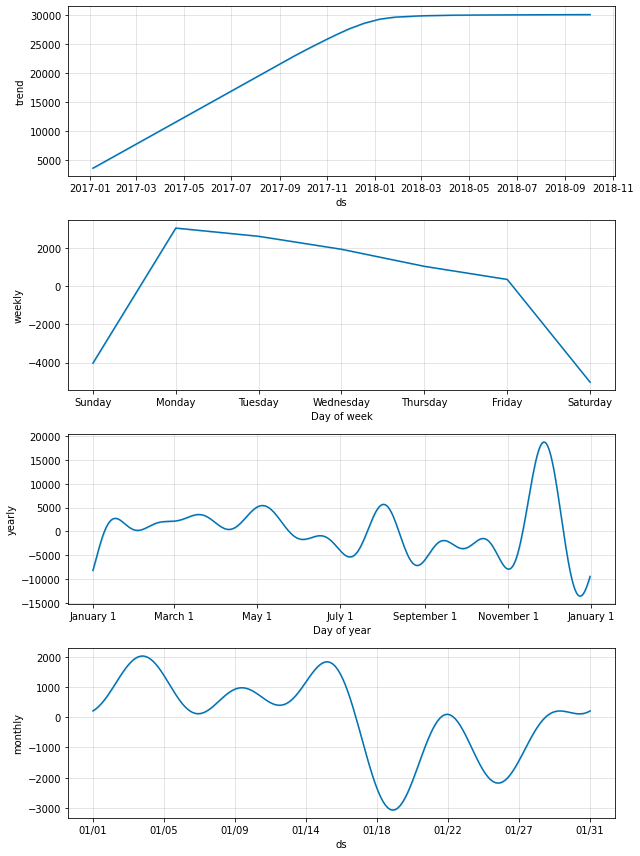

In [ ]:
# Plotando os gráficos de tendência
model_preco.plot_components(forecast_preco);

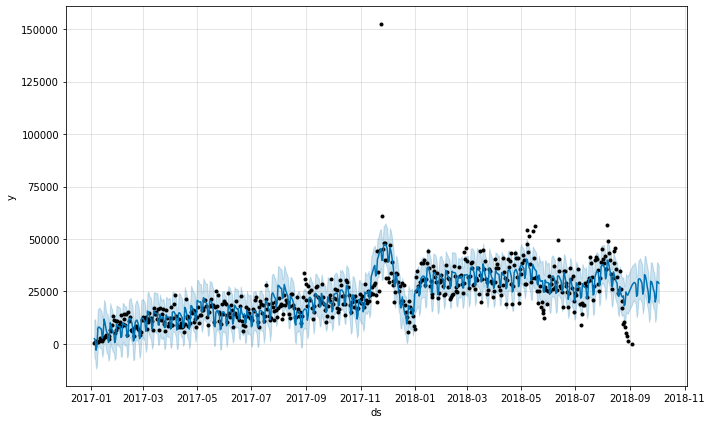

In [ ]:
# Plotando o gráfico das previsões
model_preco.plot(forecast_preco);

#### Interpretação do forecast

Ao visualizar o gráfico acima notamos a presença de um ponto que se destaca, apresentando-se com o valor superior a 150 mil reais, podendo assim ser considerado um outlier. Podemos então investigá-lo para tirar algum *insight* sobre este dado.

In [ ]:
# Identificando o outlier
ts_preco.query('y> 150000')

,ds,y
323,2017-11-24,152653.74


O outlier detectado acima aconteceu no dia 27 de novembro de 2017. Ao fazer uma rápida pesquisa na internet descobrimos que esta foi uma data onde ocorreu a **Black Friday** e portanto faz sentido termos uma grande quantidade de compras, seguida de uma grande receita sendo gerada pelo comércio.

Afim de gerar um modelo de forecast com a maior precisão possível, iremos agora desconsiderar este outlier uma vez que, por mais que tenha grandes chances de ser um dado correto, ele poderá afetar o modelo de previsão, reduzindo a sua acurácia. Este trabalho de tratamento do outlier será feito a seguir. 

### 6) Tratando os outliers

Para tratamento dos outliers iremos utilizar uma biblioteca específica chamada Isolation Forest cuja documentação pode ser conferida [aqui](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html).

Para melhor funcionamento do algorítimo iremos escalonar os dados e a seguir descobrir os índices dos registros que ele considerará uma anomalia.

In [ ]:
# Importando as bibliotecas
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

In [ ]:
# Criando o Scaler
scaler = StandardScaler()

In [ ]:
# Criando um dataframe escalonado
scaled_data = ts_preco.copy()
scaled_data.head()

,ds,y
0,2017-01-05,396.90
1,2017-01-06,916.38
2,2017-01-07,1351.90
3,2017-01-08,709.58
4,2017-01-09,673.79


In [ ]:
#  Escalonando os dados
scaled_data['scaled'] = scaler.fit_transform(pd.DataFrame(scaled_data['y']))
scaled_data.head()

,ds,y,scaled
0,2017-01-05,396.90,-1.776951
1,2017-01-06,916.38,-1.735108
2,2017-01-07,1351.90,-1.700027
3,2017-01-08,709.58,-1.751765
4,2017-01-09,673.79,-1.754648


In [ ]:
# Criação do modelo
model =  IsolationForest(contamination=0.03)
model.fit(scaled_data[['y', 'scaled']]) 
scaled_data['anomaly'] = pd.Series(model.predict(scaled_data[['y', 'scaled']]))

In [ ]:
# Verificando o resultado
scaled_data.head()

,ds,y,scaled,anomaly
0,2017-01-05,396.90,-1.776951,-1
1,2017-01-06,916.38,-1.735108,-1
2,2017-01-07,1351.90,-1.700027,-1
3,2017-01-08,709.58,-1.751765,-1
4,2017-01-09,673.79,-1.754648,-1


Como visto acima, criamos uma nova coluna chamada "anomaly" que apresenta valores 1 (não é outlier) e -1 (não é outlier). Portanto, podemos fazer uma contagem desses valores abaixo.

In [ ]:
# Contando o número de anomalias
scaled_data['anomaly'].value_counts()

 1    584
-1     19
Name: anomaly, dtype: int64

Assim, o Isolation Forest considerou 19 registros como outlier.

In [ ]:
# Encontrando os índices dos outliers
outliers_index = scaled_data.query('anomaly == "-1"').index
outliers_index

Int64Index([  0,   1,   2,   3,   4,   9, 323, 324, 326, 459, 487, 488, 490,
            494, 496, 522, 578, 579, 602],
           dtype='int64')

In [ ]:
# Deletando os outliers
ts_preco_sem_outlier = ts_preco.drop(index=outliers_index)

In [ ]:
# Verificando o shape do novo dataframe
ts_preco_sem_outlier.shape

(584, 2)

In [ ]:
# Criação do modelo sem outlier
model_preco_sem_outlier = Prophet(yearly_seasonality=True)

# Adicionando sazonalidade mensal
model_preco_sem_outlier.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Fazendo o treinamento
model_preco_sem_outlier.fit(ts_preco_sem_outlier)

# Criando um dataframe para dados futuros
future_preco_sem_outlier = model_preco_sem_outlier.make_future_dataframe(periods = 30, freq = 'D')

# Fazendo a previsão
forecast_preco_sem_outlier = model_preco_sem_outlier.predict(future_preco_sem_outlier)
forecast_preco_sem_outlier[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
584,2018-08-30,25787.314205,19622.223140,32467.467258
585,2018-08-31,24874.682136,18459.670337,31061.457485
586,2018-09-01,21083.026764,14897.738545,27942.049383
587,2018-09-02,23013.542836,16310.168199,29745.033445
588,2018-09-03,30190.766796,23516.727876,36988.902204
589,2018-09-04,31094.844329,24629.006151,37453.003740
590,2018-09-05,30993.545987,24307.590714,37197.795628
591,2018-09-06,30183.077758,23767.339787,36810.236027
592,2018-09-07,27867.226374,21389.542686,34175.847591
593,2018-09-08,23227.571548,16970.611528,29989.184343


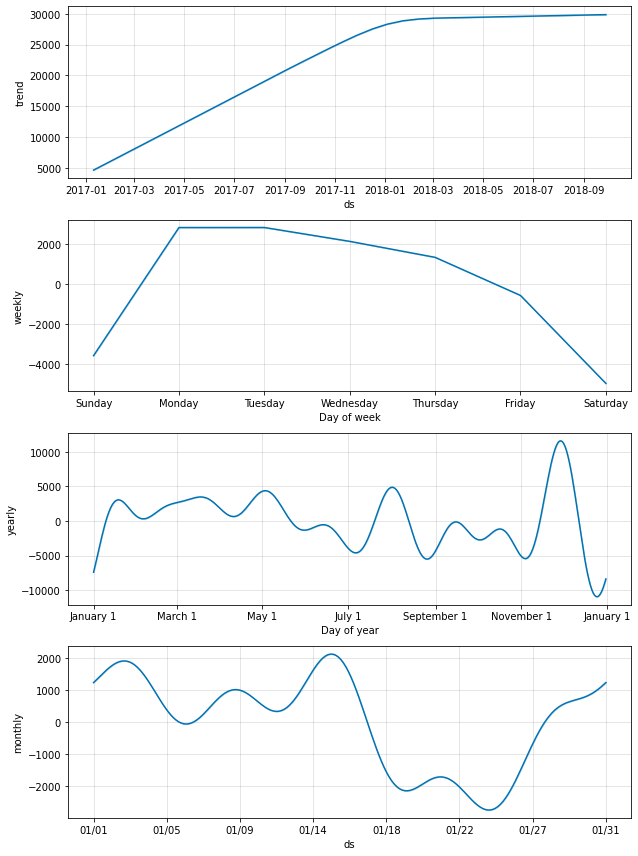

In [ ]:
# Plotando os gráficos de tendência
model_preco_sem_outlier.plot_components(forecast_preco_sem_outlier);

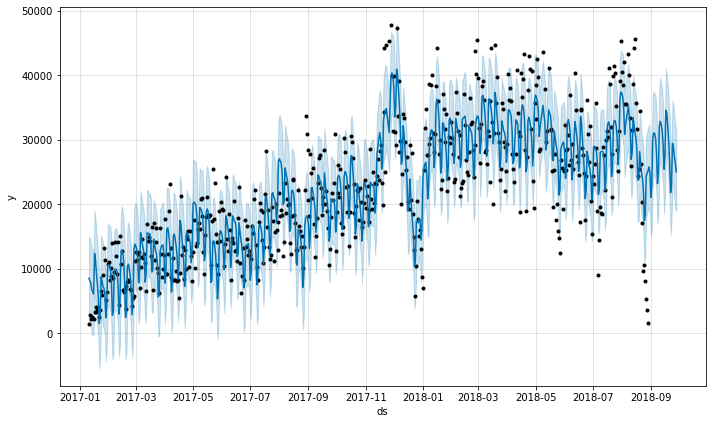

In [ ]:
# Plotando o gráfico das previsões
model_preco_sem_outlier.plot(forecast_preco_sem_outlier);

Do último plot podemos ver que os ultimos registros se mostram muito discrepantes com relação aos outros pontos, podendo assim adicionar um viés indesejado ao modelo. Assim, iremos removê-los manualmente para tentar gerar um modelo mais preciso possível.

Estes registros são facilmente localizados uma vez que, graficamente, podemos vê-los como sendo os registros dos últimos 4 dias.

In [ ]:
ts_preco_sem_outlier.tail(5)

,ds,y
597,2018-08-25,10599.41
598,2018-08-26,8070.71
599,2018-08-27,5345.91
600,2018-08-28,3673.91
601,2018-08-29,1546.04


In [ ]:
outliers_index_last = ts_preco_sem_outlier.tail(4).index
outliers_index_last

Int64Index([598, 599, 600, 601], dtype='int64')

Iremos, novamete, repetir o processo feito acima.

In [ ]:
# Deletando os outliers
ts_preco_sem_outlier.drop(index=outliers_index_last, inplace=True)

In [ ]:
# Verificando o shape do novo dataframe
ts_preco_sem_outlier.shape

(580, 2)

In [ ]:
# Criação do modelo sem outlier
model_preco_sem_outlier = Prophet(yearly_seasonality=True)

# Adicionando sazonalidade mensal
model_preco_sem_outlier.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Fazendo o treinamento
model_preco_sem_outlier.fit(ts_preco_sem_outlier)

# Criando um dataframe para dados futuros
future_preco_sem_outlier = model_preco_sem_outlier.make_future_dataframe(periods = 30, freq = 'D')

# Fazendo a previsão
forecast_preco_sem_outlier = model_preco_sem_outlier.predict(future_preco_sem_outlier)
forecast_preco_sem_outlier[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
580,2018-08-26,23352.420196,17549.547362,29705.600346
581,2018-08-27,30245.133487,24352.529818,36632.440997
582,2018-08-28,30985.336088,25111.602721,37443.595686
583,2018-08-29,31315.696237,25066.873167,37230.050279
584,2018-08-30,31127.739101,25221.736927,36790.612183
585,2018-08-31,29804.506696,23842.634688,35421.387936
586,2018-09-01,25828.615364,19391.760775,31407.545727
587,2018-09-02,27952.931484,21606.751862,34156.835973
588,2018-09-03,35338.443524,28864.286944,40935.030312
589,2018-09-04,36168.327199,29973.337462,42422.440917


Por fim, podemos plotar os respectivos gráficos.

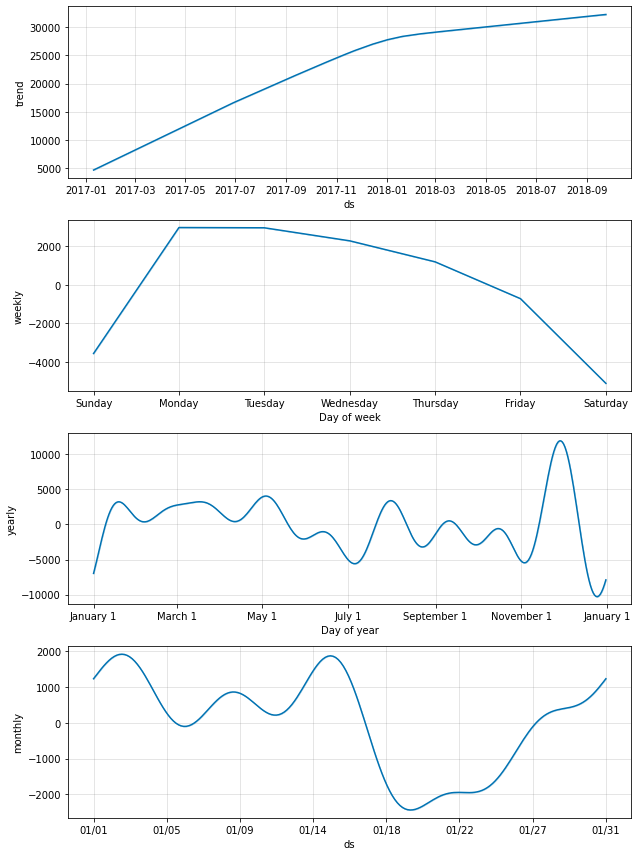

In [ ]:
# Plotando os gráficos de tendência
model_preco_sem_outlier.plot_components(forecast_preco_sem_outlier);

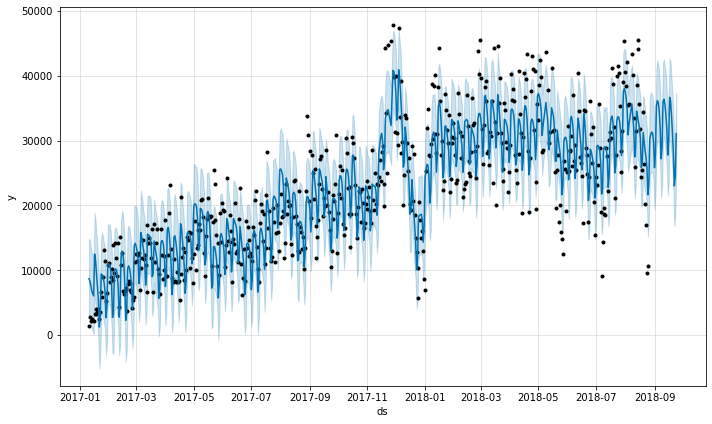

In [ ]:
# Plotando o gráfico das previsões
model_preco_sem_outlier.plot(forecast_preco_sem_outlier);

### 7) Conclusão

- Quantidades

A partir dos gráficos acima vemos que há uma clara tendência de crescimento das vendas dos produtos até janeiro de 2018, apresentando uma ligeira queda no período subsequente até novembro. Além disso verificamos que os dias da semana com maior quantidade de compras é na segunda e na terça-feira. É possível ver ainda que os fins de semana são os dias com menor vendas registradas.

Com relação ao ano vemos que o mês de dezembro é o mês com maior venda. É importante dizer que este resultado vem acompanhado de um crescimento das vendas em novembro, culminando com o ápide no último mês do ano.

Mensalmente notamos que há bastante oscilação nas vendas mas que a primeira quinzena é onde obtém-se os melhores resultados, tendo dois picos registrados até o dia 5 e por volta do dia 15. Após este dia vemos uma queda brusca seguida de um crescimento por volta do dia 22, que é o maior resultado deste fim de mês.

- Valor em dinheiro

Com relação à interpretação dos valores vemos que a tendência é muito similar ao das quantidades, mostrando que há uma relação entre as quantidades compradas e o valor gerado por tais transações. Entretanto, ainda é possível notar que o resultado é muito sensível aos outliers e que estes trazem um impacto considerável ao modelo e sua análise.

Notamos que ao remover estas anomalias (último modelo criado) vemos que há uma tendência de crescimento acelerado nas receitas até meados de janeiro de 2018, tendo a seguir um crescimento menos acentuado.

Durante a semana os principais dias para gerar receita continuam sendo na segunda e terça-feira, tendo uma queda nos seguintes dias culminando em um decepcionante resultado no fim de semana.

Anualmente continuamos tendo um grande pico de vendas no final de novembro e início de dezembro. Podemos inferir que a influência da **black friday** somado ao começo de dezembro, mês do Natal, causam um interesse maior na realização de compras, sejam para adquirir produtos em promoção ou simplesmente antecipar as compras de fim de ano.

No quesito mensal, ainda temos uma tendência maior de compras na primeira quinzena, talvez impulsionada pelo fato do salário dos consumidores sairem na primeira semana do mês. A partir da segunda quinzena vemos uma tendência de queda, provavelmente causada pela redução do poder aquisitivo após pagamentos de contas, despezas, etc. É importante notar também que apesar deste cenário, há uma tendência de crescimento nos últimos dias do mês. Podemos especular que há uma certa "empolgação" com o fato de o próximo salário estar prestes a sair ou uma coincidência com a melhor data de compra do cartão de crédito.

- Forecasting

As previsões feitas pelo modelo para os dados que já haviamos registrado encontra-se bem fiel com exceção de alguns pontos específicos, o que nos leva a crer que este modelo conseguiu se sair bem, sobretudo ao se considerar a margem de erro, que em geral englobou a maior parte dos pontos.

Assim, podemos considerar que é um modelo confiável para previsão das vendas nos próximos 30 dias, que foi o que fizemos. Obviamente, para prever dados de um futuro mais distante esta confiabilidade vai se perdendo uma vez que os erros em cada previsão vão se acumulando, gerando uma grande incerteza quanto mais longe tentamos prever os valores.